# Main document

### Initialization 

In [1]:
import pypsa
import pandas as pd
from BaseNetwork import BuildBaseNetwork
from silent_optimize import silent_optimize
import matplotlib.pyplot as plt
import numpy as np

# Task A

In [2]:
# Basemodel with one node for DK and four types of electricity generators
setup = {'DK': 
                {'OCGT': True,
                'solar': True,
                'offwind': True,
                'onwind': True},
        }

# run simuation using weather data for 2017, projected prices in 2030 and the demand from 2019 
# NB: 2019 demand data is scaled to 2030 demand projections
BaseNetwork = BuildBaseNetwork(year = 2017, cost_year = 2030, setup = setup, demand_year=2019)
silent_optimize(BaseNetwork.network)

Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 29.81it/s]


In [3]:
print(BaseNetwork.network.generators.p_nom_opt)

Generator
OCGT DK        8218.345380
solar DK        993.960115
offwind DK        0.000000
onwind DK     10696.528169
Name: p_nom_opt, dtype: float64


Year 2030 is greater than 2017, using data from last available year.


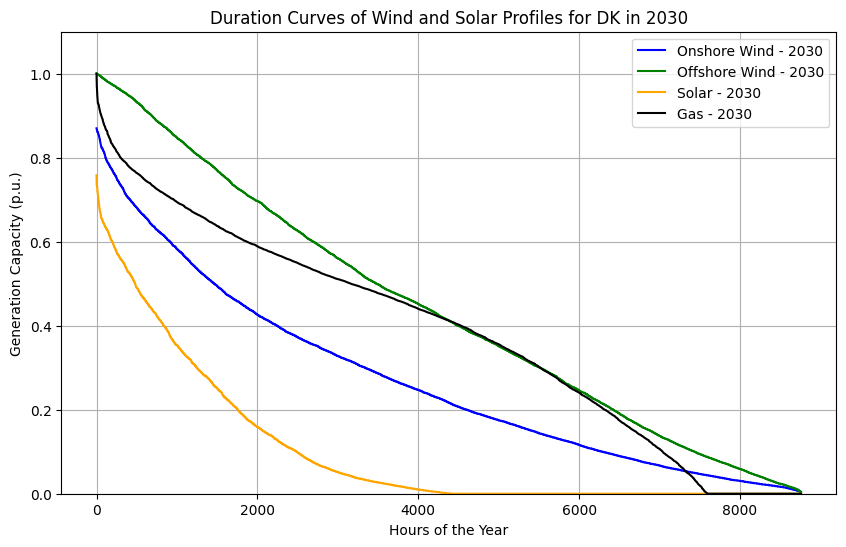

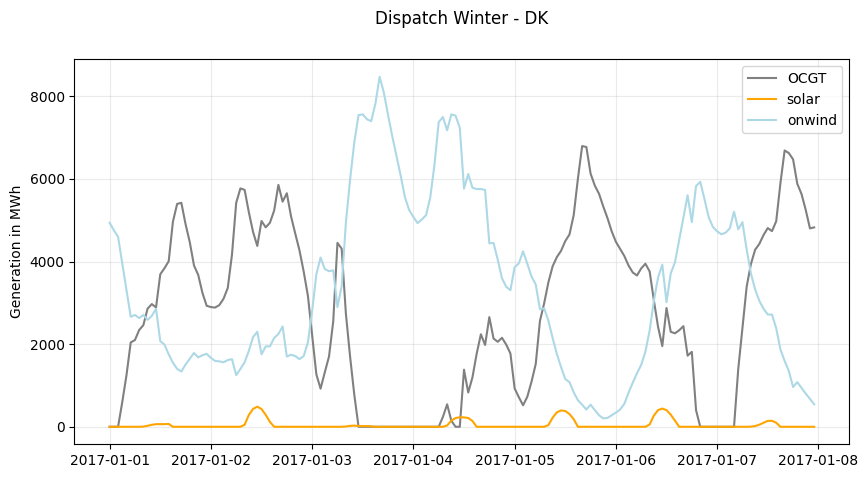

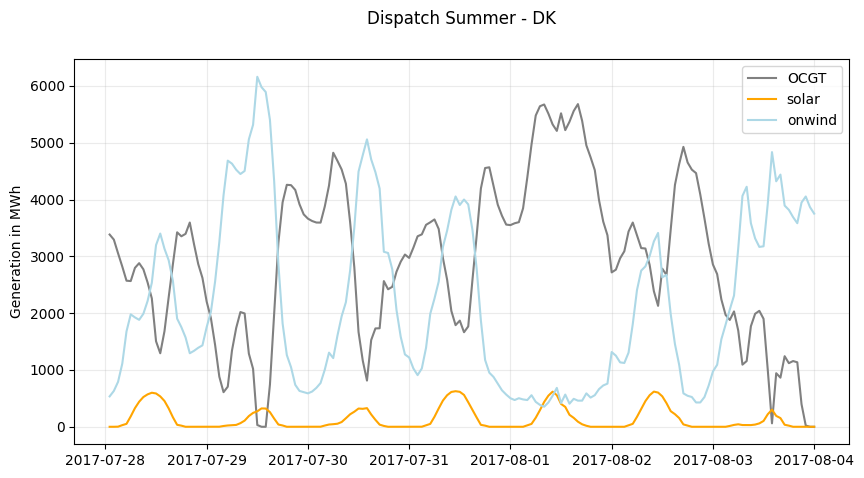

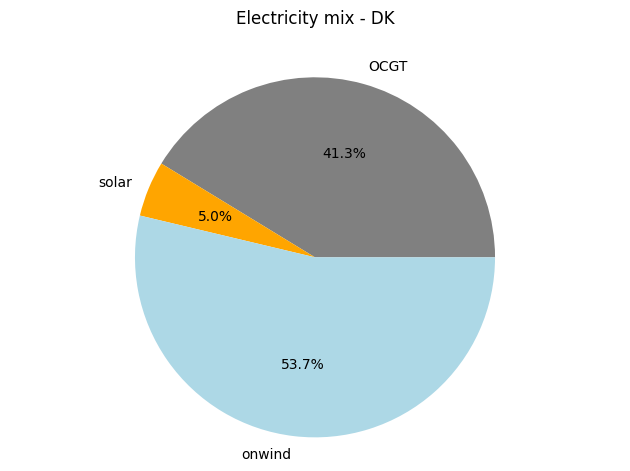

In [5]:
from Plot_scripts.PlotDispatch import PlotDispatch
from Plot_scripts.AnnualElectricityMix import AnnualElectricityMix
from Plot_scripts.DurationCurve import DurationCurve

installed_capacity = BaseNetwork.network.generators.p_nom_opt.filter(like='OCGT', axis=0).sum()
ocgt_results = BaseNetwork.network.generators_t.p.filter(like='OCGT', axis=1).sum(axis=1) / installed_capacity
ocgt_results_sorted = ocgt_results.sort_values(ascending=False).reset_index(drop=True)

DurationCurve(gas_data= ocgt_results_sorted, save_fig=True)
PlotDispatch(BaseNetwork, save_plots=True)
AnnualElectricityMix(BaseNetwork, save_plots=True)


# Task B

Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 23.39it/s]


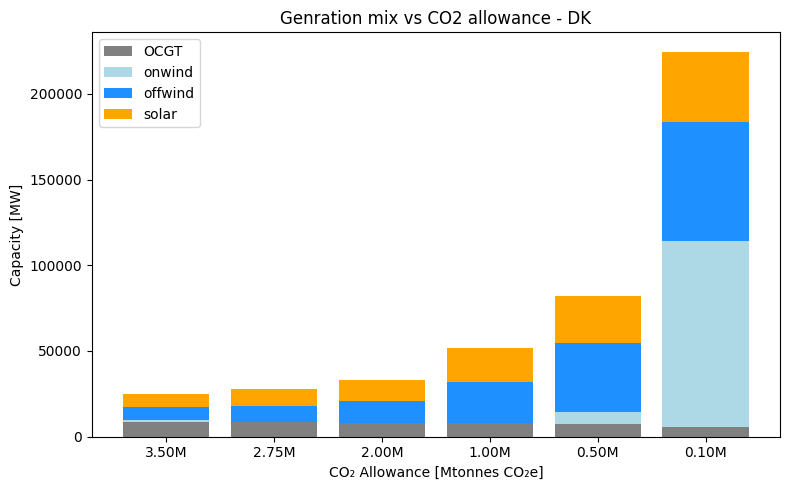

In [6]:
CO2_limits = [3_500_000, 2_750_000, 2_000_000, 1_000_000, 500_000, 100_000]

network_CO2 = {CO2_limit: None for CO2_limit in CO2_limits}

generator_opt = {
    key: {
        'OCGT': [],
        'CCGT': [],
        'onwind': [],
        'offwind': [],
        'solar': [] }
    for key in setup.keys()}

CO2_price = []
objectives = []

for CO2_limit in CO2_limits:
    # Initialize the base network
    NetworkCO2_Constraint = BuildBaseNetwork(year = 2017, cost_year = 2030, setup = setup, demand_year=2019)

    #Add CO2 constraint to the network
    NetworkCO2_Constraint.network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=CO2_limit)

    # Solve the network with the CO2 constraint
    silent_optimize(NetworkCO2_Constraint.network)

    network_CO2[CO2_limit] = NetworkCO2_Constraint.network

    # Extract the results
    CO2_price.append(-NetworkCO2_Constraint.network.global_constraints.mu['CO2Limit'])
    objectives.append(NetworkCO2_Constraint.network.objective)
    generators = NetworkCO2_Constraint.network.generators.p_nom_opt.keys()
    for region in NetworkCO2_Constraint.regions:
        for generator in generators:
            if generator.split(' ')[1] == region:
                generator_opt[region][generator.split(' ')[0]].append(NetworkCO2_Constraint.network.generators.p_nom_opt[generator].sum())

colors_tab = NetworkCO2_Constraint.colors

x = np.arange(len(CO2_limits))  # [0, 1]

for country, techs in generator_opt.items():
    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(CO2_limits))  # for stacking

    for tech, values in techs.items():
        if values:  # skip empty lists
            plt.bar(x, values, bottom=bottom, label=tech, color=colors_tab[tech])
            bottom += np.array(values)

    plt.xticks(x, [f"{val/1_000_000:.2f}M" for val in CO2_limits])
    plt.title(f"Genration mix vs CO2 allowance - {country}")
    plt.xlabel("CO₂ Allowance [Mtonnes CO₂e]")
    plt.ylabel("Capacity [MW]")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./Plots/Task_B_CO2_allowence_{country}_ny.png", dpi=300)
    plt.show()

Peak price day: 2017-01-21


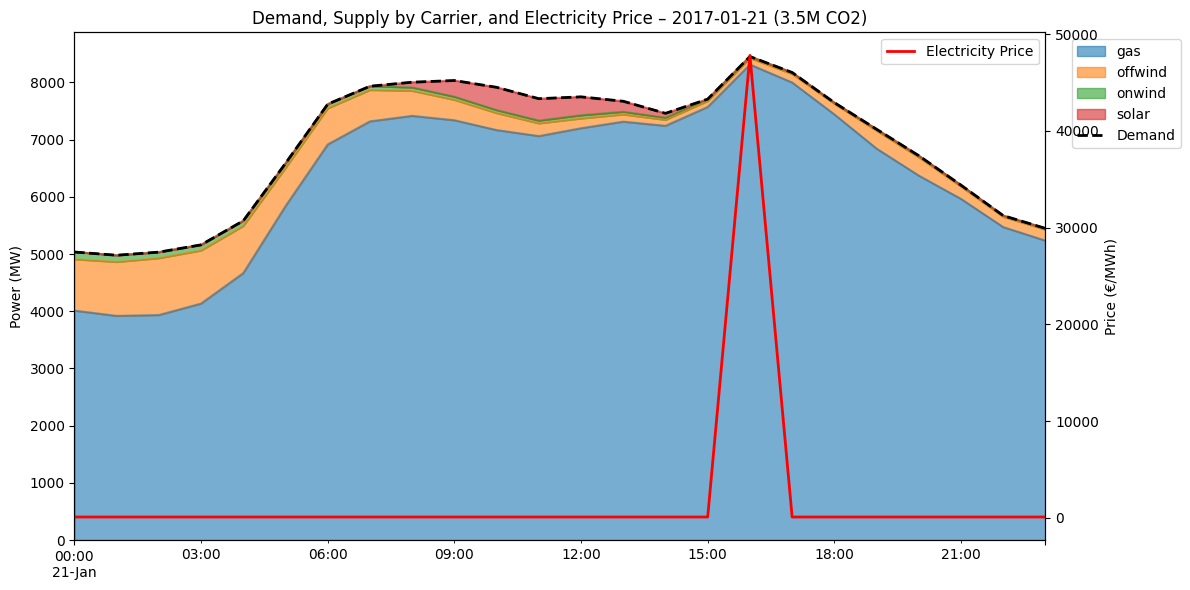

In [7]:
def plot_peak_day_supply_demand(network, title_suffix="", day=None):
    """
    Plots demand, supply by carrier, and average electricity price
    for the day with the highest average electricity price.

    Parameters:
        network: PyPSA network (already optimized)
        title_suffix: Optional string to add to the plot title
    """
    # 1. Find the peak price day
    avg_prices = network.buses_t.marginal_price.mean(axis=1)
    if day is None:
        peak_day = avg_prices.idxmax().strftime("%Y-%m-%d")
        ts_day = pd.date_range(f"{peak_day} 00:00", f"{peak_day} 23:00", freq="h")
    else:
        peak_day = day
        ts_day = pd.date_range(f"{peak_day} 00:00", f"{peak_day} 23:00", freq="h")
    
    print(f"Peak price day: {peak_day}")

    # 2. Demand
    demand = network.loads_t.p.loc[ts_day].sum(axis=1)

    # 3. Generation by carrier
    generation = network.generators_t.p.loc[ts_day]
    carrier_map = network.generators.carrier
    generation_by_carrier = generation.T.groupby(carrier_map).sum().T

    # 4. Electricity price (average across buses)
    price = network.buses_t.marginal_price.loc[ts_day].mean(axis=1)

    # 5. Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Stack plot of generation
    generation_by_carrier.plot.area(ax=ax1, stacked=True, alpha=0.6)
    
    # Demand line
    demand.plot(ax=ax1, label="Demand", color="black", linestyle="--", linewidth=2)

    ax1.set_ylabel("Power (MW)")
    ax1.set_title(f"Demand, Supply by Carrier, and Electricity Price – {peak_day} {title_suffix}")
    ax1.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    # Add price on secondary axis
    ax2 = ax1.twinx()
    price.plot(ax=ax2, color="red", label="Electricity Price", linewidth=2)
    ax2.set_ylabel("Price (€/MWh)")
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

# Select the day with the spike
n_4 = network_CO2[3_500_000] 

plot_peak_day_supply_demand(n_4, title_suffix="(3.5M CO2)")

# Task C

In [8]:
# Basemodel with DK
setup = {'DK': 
                {'OCGT': True,
                'solar': True,
                'offwind': True,
                'onwind': True},
                }

years = [2013, 2014, 2015, 2016, 2017] #used to investigate different weather years

network_year = {year: None for year in years}

generator_opt_year = {
    key: {
        'OCGT': [],
        'onwind': [],
        'offwind': [],
        'solar': [] }
    for key in setup.keys()}

objectives_year = []

for year in years:
    # Initialize the base network
    Network_Yearly = BuildBaseNetwork(year = year, cost_year = 2030, setup = setup, demand_year=2019)

    # Solve the network for the specific year
    silent_optimize(Network_Yearly.network)

    network_year[year] = Network_Yearly.network

    # Extract the results
    objectives_year.append(Network_Yearly.network.objective)
    generators_year = Network_Yearly.network.generators.p_nom_opt.keys()
    for region in Network_Yearly.regions:
        for generator in generators_year:
            if generator.split(' ')[1] == region:
                generator_opt_year[region][generator.split(' ')[0]].append(Network_Yearly.network.generators.p_nom_opt[generator].sum())

Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 23.63it/s]


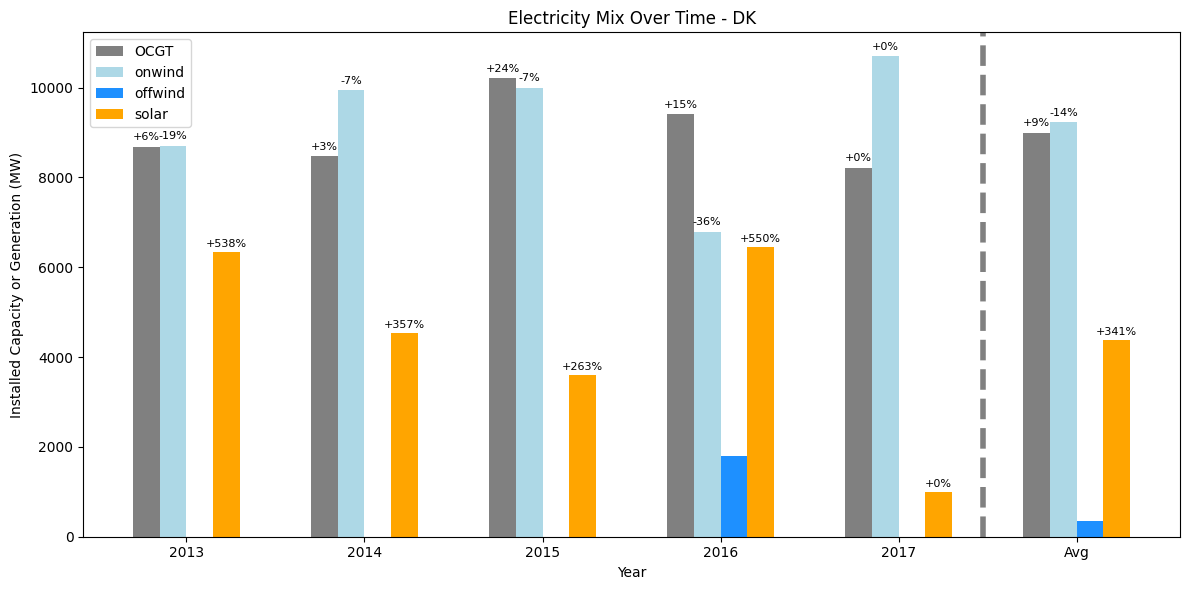

In [9]:
def plot_generation_mix_with_percentage_labels(years, generator_opt_year, base_year=2017):
    x = np.arange(len(years) + 1)  # One extra slot for 'Average'
    bar_width = 0.15

    for country, techs in generator_opt_year.items():
        plt.figure(figsize=(12, 6))

        for i, tech in enumerate(techs.keys()):
            values = techs.get(tech, [])
            if not values:
                continue

            # Get base value for normalization
            try:
                base_index = years.index(base_year)
                base_value = values[base_index]
            except (ValueError, IndexError):
                print(f"Warning: Base year {base_year} not found or no data for tech {tech}. Skipping label.")
                base_value = 0

            avg = np.mean(values)
            values_with_avg = values + [avg]

            bar_positions = x + i * bar_width
            bars = plt.bar(bar_positions, values_with_avg, width=bar_width, label=tech, color=colors_tab[tech])

            # Add percentage labels relative to base year
            for j, (bar, val) in enumerate(zip(bars, values_with_avg)):
                if base_value != 0:
                    pct_change = ((val - base_value) / base_value) * 100
                    label = f"{pct_change:+.0f}%"
                else:
                    label = ""  # Avoid division by zero

                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + max(values_with_avg) * 0.01,
                    label,
                    ha='center',
                    va='bottom',
                    fontsize=8
                )
        # Add vertical dotted line before 'Avg'
        split_position = x[-2] + bar_width * len(techs) + 0.1  # End of last year group

        plt.axvline(x=split_position , color='gray', linestyle='--', linewidth=4)

        xtick_labels = years + ['Avg']
        plt.xticks(x + bar_width * (len(techs.keys()) - 1) / 2, xtick_labels)

        plt.title(f"Electricity Mix Over Time - {country}")
        plt.xlabel("Year")
        plt.ylabel("Installed Capacity or Generation (MW)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'./plots/sectionC.png', dpi=300, bbox_inches='tight')

        plt.show()
colors_tab = Network_Yearly.colors
plot_generation_mix_with_percentage_labels(years, generator_opt_year, base_year=2017)

# Task D

In [ ]:
from ExpandedNetwork import ExpandedNetwork
from Plot_scripts.DispatchSoC import PlotDispatchSoC
from silent_optimize import silent_optimize
from Plot_scripts.AnnualElectricityMix import AnnualElectricityMix

year = 2017
cost_year = 2030
demand_year = 2019 # again the profile from 2019 will be used and scaled to 2030 values in DataGeneration
setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            }}

Expanded_Network = ExpandedNetwork(year = year, cost_year = cost_year, setup = setup, demand_year=demand_year)
silent_optimize(Expanded_Network.network)

Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 31.41it/s]


In [11]:
print(Expanded_Network.network.stores.e_nom_opt)

Store
battery storage DK        1835.507795
H2 (l) storage tank DK       0.000000
Name: e_nom_opt, dtype: float64


In [ ]:
print(Expanded_Network.network.storage_units.p_nom_opt)

Series([], Name: p_nom_opt, dtype: float64)


c:\Users\jpspa\OneDrive - Danmarks Tekniske Universitet\master\4. semester\Integrated Energy Grids\ieg\Plot_scripts\DispatchSoC.py:60: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



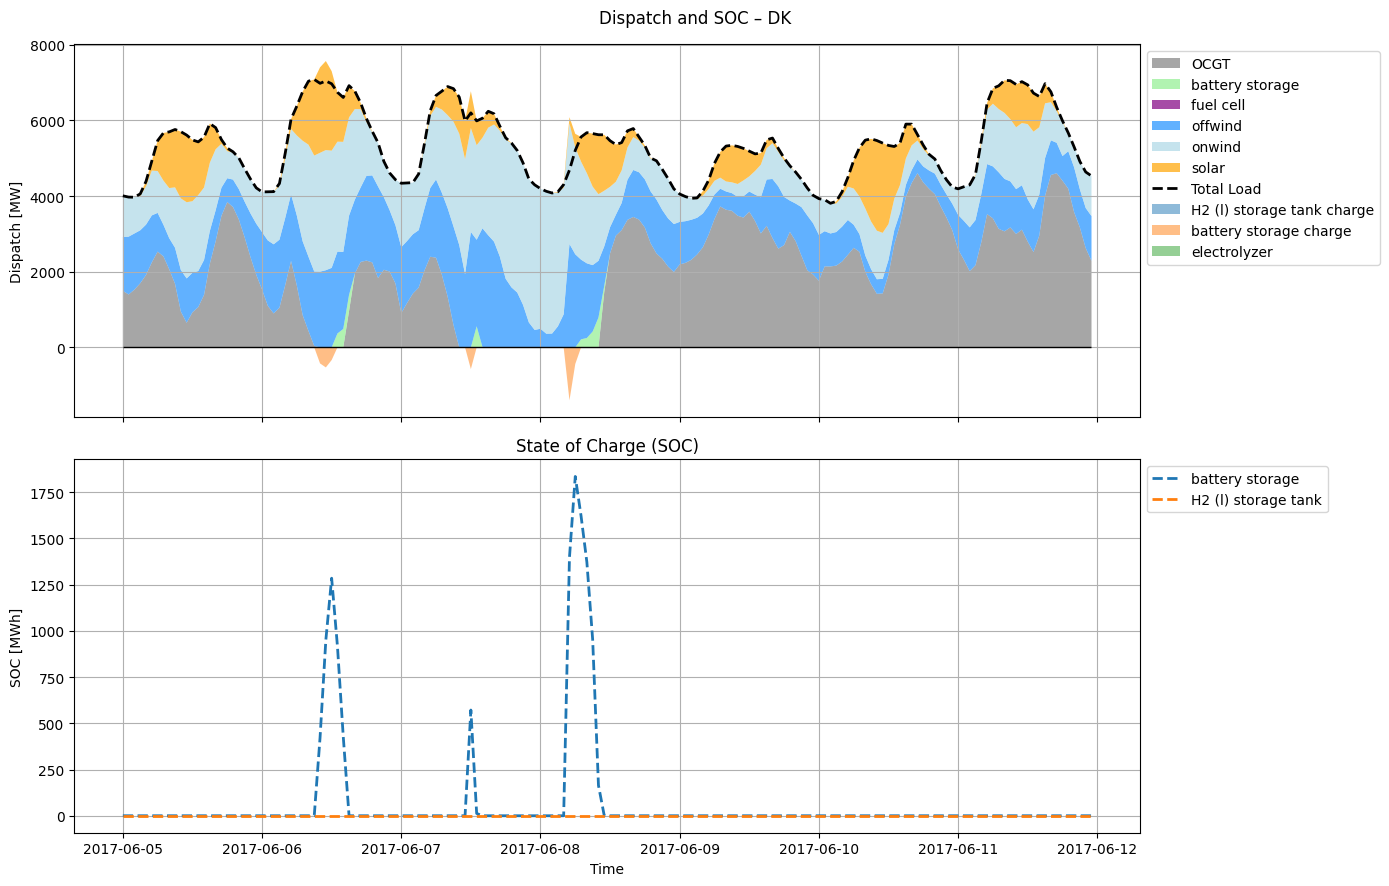

In [ ]:
PlotDispatchSoC(Expanded_Network, start="2017-06-05 00:00", end="2017-06-11 23:00", save_plots=True)

# Task E

Initially we want to see what the price becomes for different CO2 allowance limits

In [ ]:
CO2_limits = [3_500_000, 2_750_000, 2_000_000, 1_000_000, 500_000, 100_000]

network_CO2 = {CO2_limit: None for CO2_limit in CO2_limits}

generator_opt = {
    key: {
        'OCGT': [],
        'onwind': [],
        'offwind': [],
        'solar': [] }
    for key in setup.keys()}

storage_opt = {
    key: {
        'battery storage': [],
        'H2 (l) storage tank': [] }
    for key in setup.keys()}

CO2_price = []
objectives = []

for CO2_limit in CO2_limits:
    # Initialize the base network
    NetworkCO2_Constraint = ExpandedNetwork(year = 2017, cost_year = 2030, setup = setup, demand_year=2019)

    #Add CO2 constraint to the network
    NetworkCO2_Constraint.network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=CO2_limit)

    # Solve the network with the CO2 constraint
    silent_optimize(NetworkCO2_Constraint.network)

    network_CO2[CO2_limit] = NetworkCO2_Constraint.network

    # Extract the results
    CO2_price.append(-NetworkCO2_Constraint.network.global_constraints.mu['CO2Limit'])
    objectives.append(NetworkCO2_Constraint.network.objective)
    generators = NetworkCO2_Constraint.network.generators.p_nom_opt.keys()
    for region in NetworkCO2_Constraint.regions:
        for generator in generators:
            if generator.split(' ')[1] == region:
                generator_opt[region][generator.split(' ')[0]].append(NetworkCO2_Constraint.network.generators.p_nom_opt[generator].sum())

    for region in NetworkCO2_Constraint.regions:
        for store in NetworkCO2_Constraint.network.stores.index:
            if store.endswith(region):
                store_type = store.replace(f" {region}", "")
                if store_type in storage_opt[region]:
                    storage_opt[region][store_type].append(NetworkCO2_Constraint.network.stores.e_nom_opt[store])

x = np.arange(len(CO2_limits))  # [0, 1]

for country, techs in generator_opt.items():
    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(CO2_limits))  # for stacking

    for tech, values in techs.items():
        if values:  # skip empty lists
            plt.bar(x, values, bottom=bottom, label=tech)
            bottom += np.array(values)

    plt.xticks(x, [f"{val/1_000_000:.2f}M" for val in CO2_limits])
    plt.title(f"Electricity Mix for {country}")
    plt.xlabel("CO₂ Allowance")
    plt.ylabel("Capacity")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
for country, techs in storage_opt.items(): 
    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(CO2_limits))  # for stacking

    for tech, values in techs.items():
        if values:  # skip empty lists
            plt.bar(x, values, bottom=bottom, label=tech)
            bottom += np.array(values)

    plt.xticks(x, [f"{val/1_000_000:.2f}M" for val in CO2_limits])
    plt.title(f"Storage Mix for {country}")
    plt.xlabel("CO₂ Allowance")
    plt.ylabel("Capacity")
    plt.legend()
    plt.tight_layout()
    plt.show()

This yield the following co2 prices: 

[116.7309410181756, 203.92492840539643, 358.3068130315317, 785.7350090626849, 1561.5776655408747, 5023.186297498649]


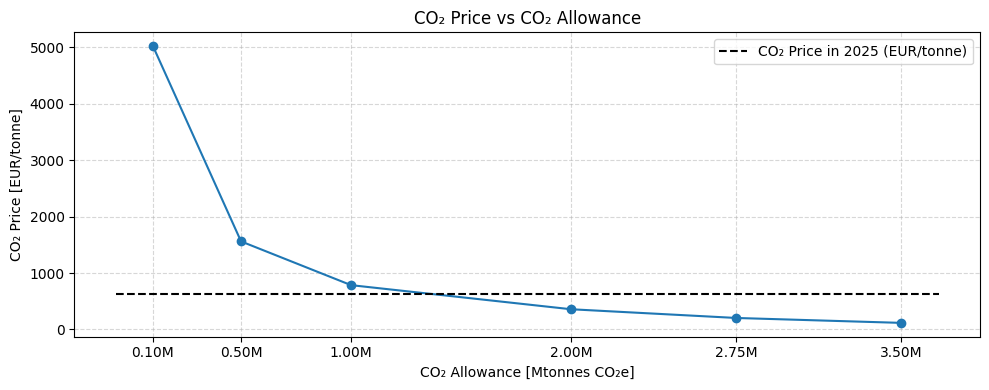

\begin{table}
\caption{CO₂ Price as a Function of CO₂ Limit}
\label{tab:co2_price_limits}
\begin{tabular}{lr}
\toprule
CO₂ Limit [tCO₂] & CO₂ Price [€/tCO₂] \\
\midrule
3\,500\,000 & 116.7 \\
2\,750\,000 & 203.9 \\
2\,000\,000 & 358.3 \\
1\,000\,000 & 785.7 \\
500\,000 & 1561.6 \\
100\,000 & 5023.2 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
print([val for val in CO2_price])
plt.figure(figsize=(10, 4))
plt.plot(CO2_limits, CO2_price, marker='o')
plt.xticks(CO2_limits, [f"{val/1_000_000:.2f}M" for val in CO2_limits])
plt.xlabel("CO₂ Allowance [Mtonnes CO₂e]")
plt.ylabel("CO₂ Price [EUR/tonne]")
# Force axis limits update before hlines
plt.gca().relim()
plt.gca().autoscale_view()

# Get x-limits from the plot
xmin, xmax = plt.xlim()
plt.hlines(y=85.2*7.45, xmin=xmin, xmax=xmax, color='black', linestyle='--', label='CO₂ Price in 2025 (EUR/tonne)')
plt.title("CO₂ Price vs CO₂ Allowance")

plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# df = pd.DataFrame({
#     "CO₂ Limit [tCO₂]": CO2_limits,
#     "CO₂ Price [€/tCO₂]": CO2_price
# })

# # Format large numbers for LaTeX (optional)
# df["CO₂ Limit [tCO₂]"] = df["CO₂ Limit [tCO₂]"].map(lambda x: f"{x:,}".replace(",", "\\,"))

# # Generate LaTeX table
# latex_table = df.to_latex(index=False,
#                           caption="CO₂ Price as a Function of CO₂ Limit",
#                           label="tab:co2_price_limits",
#                           float_format="%.1f")

# print(latex_table)

Imposing the following co2 prices would give the following generation mix and storage: 

Updated marginal cost for OCGT DK: 87.84995121951219 €/MWh


Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 31.32it/s]


System cost at €117/t: 3834606303.31 €
Total OCGT dispatch at €117/t: 17628717.21 MWh
Updated marginal cost for OCGT DK: 105.0759512195122 €/MWh


Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 34.75it/s]


System cost at €204/t: 4103149899.75 €
Total OCGT dispatch at €204/t: 13869669.72 MWh
Updated marginal cost for OCGT DK: 135.5679512195122 €/MWh


Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 34.28it/s]


System cost at €358/t: 4467133990.59 €
Total OCGT dispatch at €358/t: 10107918.63 MWh
Updated marginal cost for OCGT DK: 220.3119512195122 €/MWh


Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 31.80it/s]


System cost at €786/t: 5055909935.84 €
Total OCGT dispatch at €786/t: 5046590.88 MWh
Updated marginal cost for OCGT DK: 373.9599512195122 €/MWh


Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 30.84it/s]


System cost at €1562/t: 5607375880.27 €
Total OCGT dispatch at €1562/t: 2522378.52 MWh
Updated marginal cost for OCGT DK: 1059.2379512195123 €/MWh


Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 30.70it/s]


System cost at €5023/t: 6314987964.44 €
Total OCGT dispatch at €5023/t: 507251.99 MWh


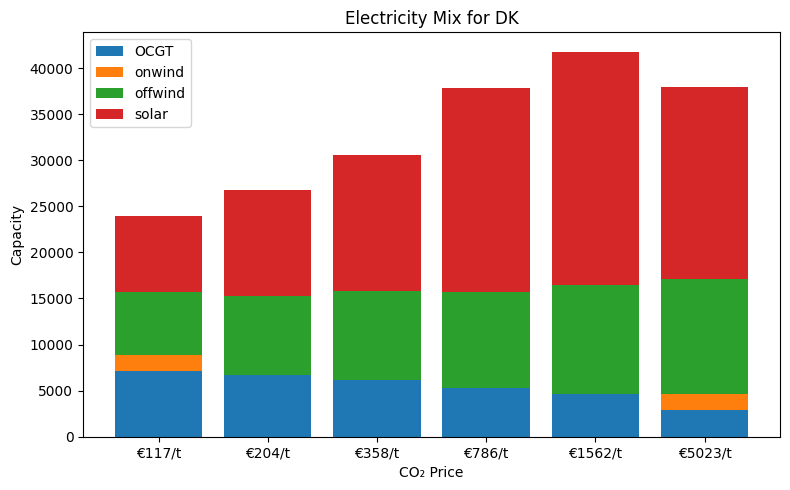

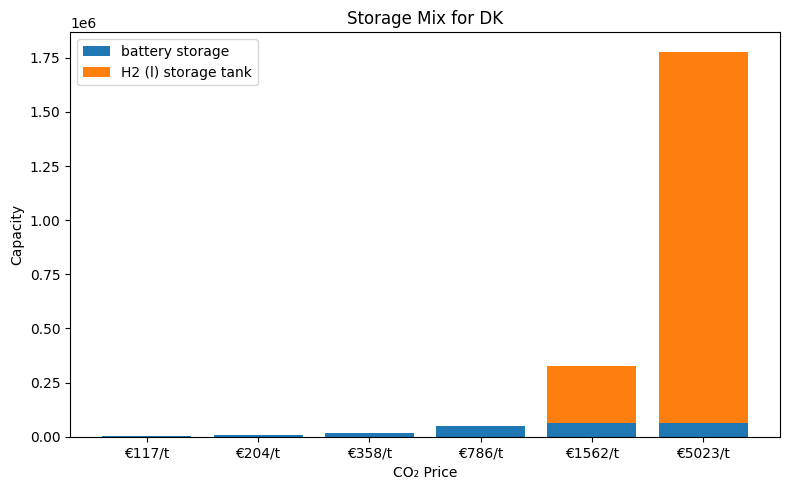

In [ ]:
from ExpandedNetwork import ExpandedNetwork
from Plot_scripts.DispatchSoC import PlotDispatchSoC
from silent_optimize import silent_optimize
from Plot_scripts.AnnualElectricityMix import AnnualElectricityMix

import numpy as np
import matplotlib.pyplot as plt

# Set CO2 prices to test
CO2_prices = [round(p) for p in [116.7309410181756, 203.92492840539643, 358.3068130315317, 785.7350090626849, 1561.5776655408747, 5023.186297498649]]


setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            }}

network_CO2_price = {price: None for price in CO2_prices}

generator_opt = {
    key: {
        'OCGT': [],
        'onwind': [],
        'offwind': [],
        'solar': [] }
    for key in setup.keys()}

storage_opt = {
    key: {
        'battery storage': [],
        'H2 (l) storage tank': [] }
    for key in setup.keys()}

objectives = []

for price in CO2_prices:
    # Build the network
    Expanded_Network = ExpandedNetwork(year=2017, cost_year=2030, setup=setup, demand_year=2019)

    # Add CO2 cost directly to OCGT DK generator
    gas_generator_name = "OCGT DK"
    gas_carrier = "OCGT"
    co2_intensity = Expanded_Network.costs.at[gas_carrier, "CO2 intensity"]  # tCO2/MWh_th
    co2_cost = price * co2_intensity  # €/MWh_th

    if gas_generator_name in Expanded_Network.network.generators.index:
        Expanded_Network.network.generators.at[gas_generator_name, 'marginal_cost'] += co2_cost
        print(f"Updated marginal cost for {gas_generator_name}: {Expanded_Network.network.generators.at[gas_generator_name, 'marginal_cost']} €/MWh")
    else:
        print(f"Warning: Generator '{gas_generator_name}' not found in network.")

    # Solve the network
    silent_optimize(Expanded_Network.network)

    # Print objective (system cost)
    print(f"System cost at €{price}/t: {Expanded_Network.network.objective:.2f} €")

    # Print total OCGT dispatch
    if gas_generator_name in Expanded_Network.network.generators_t.p.columns:
        ocgt_dispatch = Expanded_Network.network.generators_t.p[gas_generator_name].sum()
        print(f"Total OCGT dispatch at €{price}/t: {ocgt_dispatch:.2f} MWh")
    else:
        print(f"Dispatch data for '{gas_generator_name}' not available.")

    network_CO2_price[price] = Expanded_Network.network
    objectives.append(Expanded_Network.network.objective)

    # Extract results
    generators = Expanded_Network.network.generators.p_nom_opt.keys()
    for region in Expanded_Network.regions:
        for generator in generators:
            if generator.split(' ')[1] == region:
                generator_opt[region][generator.split(' ')[0]].append(Expanded_Network.network.generators.p_nom_opt[generator].sum())

    for region in Expanded_Network.regions:
        for store in Expanded_Network.network.stores.index:
            if store.endswith(region):
                store_type = store.replace(f" {region}", "")
                if store_type in storage_opt[region]:
                    storage_opt[region][store_type].append(Expanded_Network.network.stores.e_nom_opt[store])

x = np.arange(len(CO2_prices))
labels = [f"€{val}/t" for val in CO2_prices]

for country, techs in generator_opt.items():
    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(CO2_prices))

    for tech, values in techs.items():
        if values:
            plt.bar(x, values, bottom=bottom, label=tech)
            bottom += np.array(values)

    plt.xticks(x, labels)
    plt.title(f"Electricity Mix for {country}")
    plt.xlabel("CO₂ Price")
    plt.ylabel("Capacity")
    plt.legend()
    plt.tight_layout()
    plt.show()

for country, techs in storage_opt.items(): 
    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(CO2_prices))

    for tech, values in techs.items():
        if values:
            plt.bar(x, values, bottom=bottom, label=tech)
            bottom += np.array(values)

    plt.xticks(x, labels)
    plt.title(f"Storage Mix for {country}")
    plt.xlabel("CO₂ Price")
    plt.ylabel("Capacity")
    plt.legend()
    plt.tight_layout()
    plt.show()


However this is unrealistic since our system does not include all the technologies the real system have and thus a projected value for the co2 price will be used instead. 

The value is: 150 EUR/ton CO2e 

Updated marginal cost for OCGT DK: 94.3839512195122 €/MWh


Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 31.97it/s]


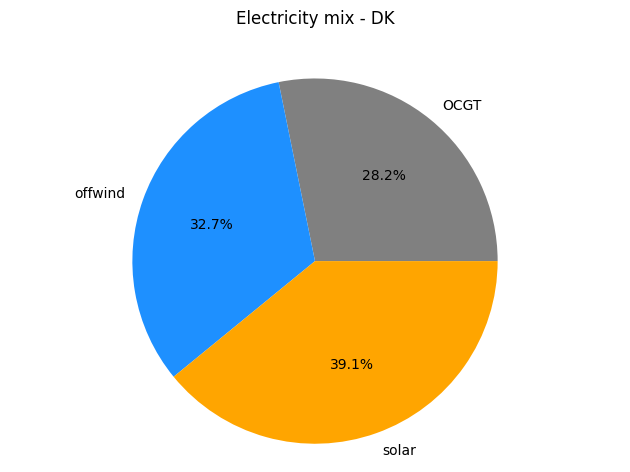

In [ ]:
from ExpandedNetwork import ExpandedNetwork
from Plot_scripts.DispatchSoC import PlotDispatchSoC
from silent_optimize import silent_optimize
from Plot_scripts.AnnualElectricityMix import AnnualElectricityMix

year = 2017
cost_year = 2030
demand_year = 2019

setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            }}

# Set CO2 price in €/tCO2
co2_price = 150

# Build the network
Expanded_Network = ExpandedNetwork(year=year, cost_year=cost_year, setup=setup, demand_year=demand_year)

# Add CO2 cost directly to OCGT DK generator
gas_generator_name = "OCGT DK"
gas_carrier = "OCGT"
co2_intensity = Expanded_Network.costs.at[gas_carrier, "CO2 intensity"]  # tCO2/MWh_th
co2_cost = co2_price * co2_intensity  # €/MWh_th

if gas_generator_name in Expanded_Network.network.generators.index:
    Expanded_Network.network.generators.at[gas_generator_name, 'marginal_cost'] += co2_cost
    print(f"Updated marginal cost for {gas_generator_name}: {Expanded_Network.network.generators.at[gas_generator_name, 'marginal_cost']} €/MWh")
else:
    print(f"Warning: Generator '{gas_generator_name}' not found in network.")



# Optional debug print
#print(f"Applied CO₂ price: {co2_price} €/t to carrier '{gas_carrier}' with intensity {co2_intensity} tCO₂/MWh.")
#print(Expanded_Network.network.generators.loc[gen_idx, ['carrier', 'marginal_cost']])

# Solve the network
silent_optimize(Expanded_Network.network)
AnnualElectricityMix(Expanded_Network, save_plots=False)


Updated marginal cost for OCGT DK: 94.3839512195122 €/MWh


Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 31.97it/s]


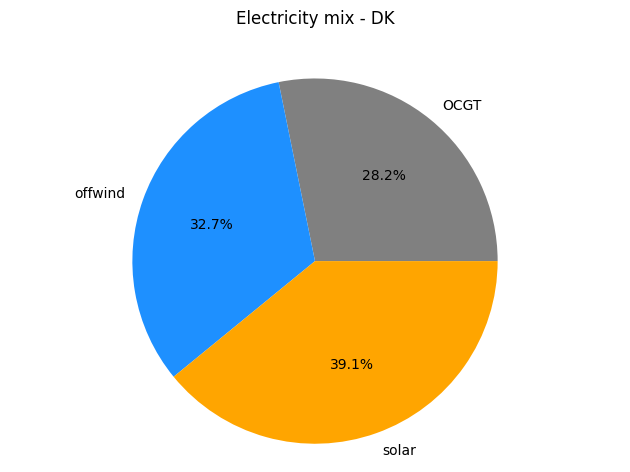

In [ ]:
from ExpandedNetwork import ExpandedNetwork
from Plot_scripts.DispatchSoC import PlotDispatchSoC
from silent_optimize import silent_optimize
from Plot_scripts.AnnualElectricityMix import AnnualElectricityMix

year = 2017
cost_year = 2030
demand_year = 2019

setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            }}

# Set CO2 price in €/tCO2
co2_price = 150

# Build the network
Expanded_Network = ExpandedNetwork(year=year, cost_year=cost_year, setup=setup, demand_year=demand_year)

# Add CO2 cost directly to OCGT DK generator
gas_generator_name = "OCGT DK"
gas_carrier = "OCGT"
co2_intensity = Expanded_Network.costs.at[gas_carrier, "CO2 intensity"]  # tCO2/MWh_th
co2_cost = co2_price * co2_intensity  # €/MWh_th

if gas_generator_name in Expanded_Network.network.generators.index:
    Expanded_Network.network.generators.at[gas_generator_name, 'marginal_cost'] += co2_cost
    print(f"Updated marginal cost for {gas_generator_name}: {Expanded_Network.network.generators.at[gas_generator_name, 'marginal_cost']} €/MWh")
else:
    print(f"Warning: Generator '{gas_generator_name}' not found in network.")



# Optional debug print
#print(f"Applied CO₂ price: {co2_price} €/t to carrier '{gas_carrier}' with intensity {co2_intensity} tCO₂/MWh.")
#print(Expanded_Network.network.generators.loc[gen_idx, ['carrier', 'marginal_cost']])

# Solve the network
silent_optimize(Expanded_Network.network)
AnnualElectricityMix(Expanded_Network, save_plots=False)


# Task F 
Note: The plot generated in PlotInternationalDispatchSoC is not correct for Norway, as we were struggling with the visualization of the Pumped Hydro Storage.

Updated marginal cost for OCGT DK: 94.3839512195122 €/MWh


Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00,  8.68it/s]
c:\Users\Jeppe Urup Byberg\OneDrive\Dokumenter\GitHub\ieg\Plot_scripts\DispatchSoCInternational.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  fallback_cmap = cm.get_cmap('tab20')  # or any other colormap


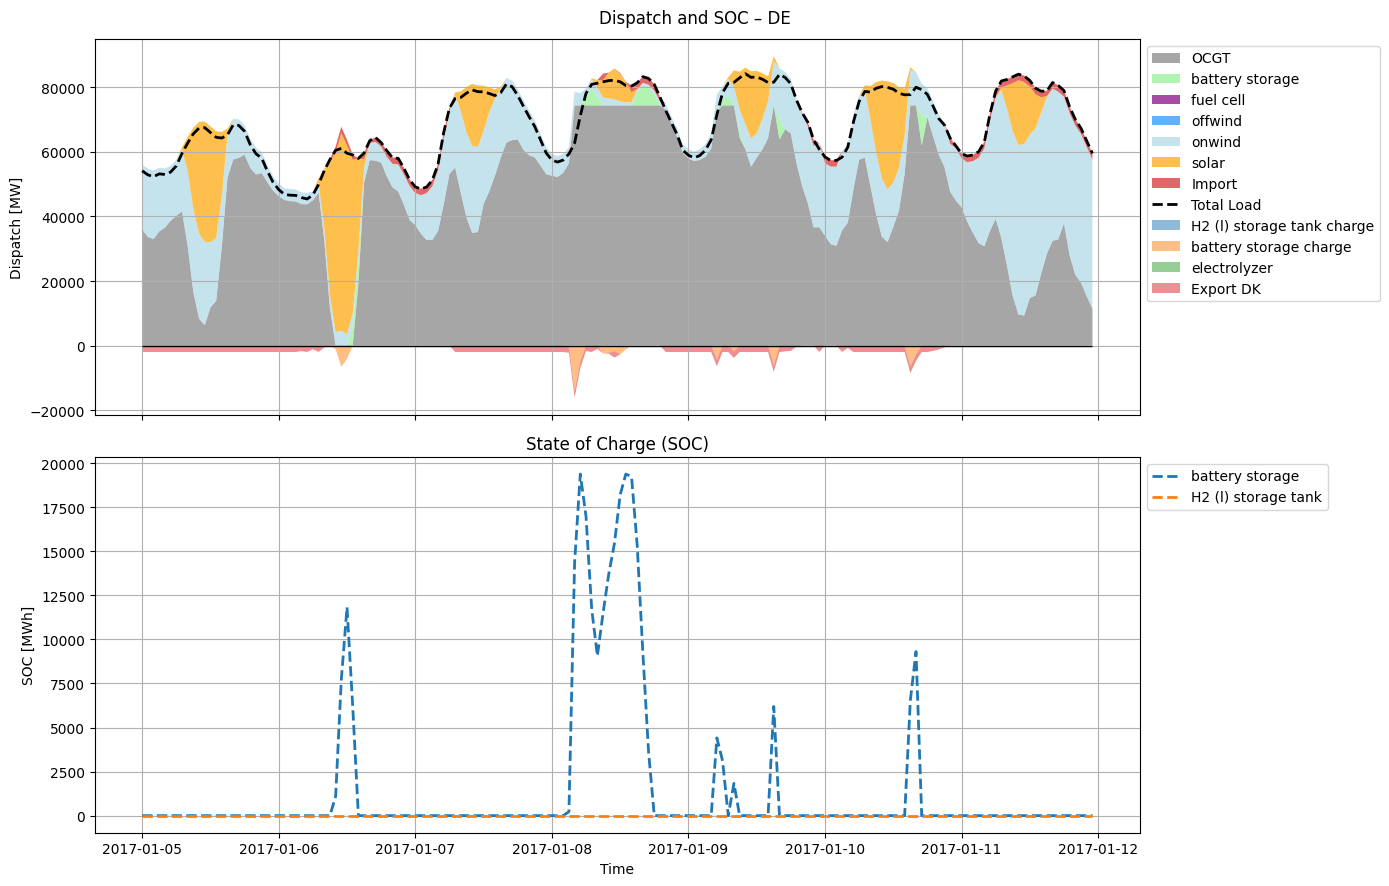

c:\Users\Jeppe Urup Byberg\OneDrive\Dokumenter\GitHub\ieg\Plot_scripts\DispatchSoCInternational.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  fallback_cmap = cm.get_cmap('tab20')  # or any other colormap


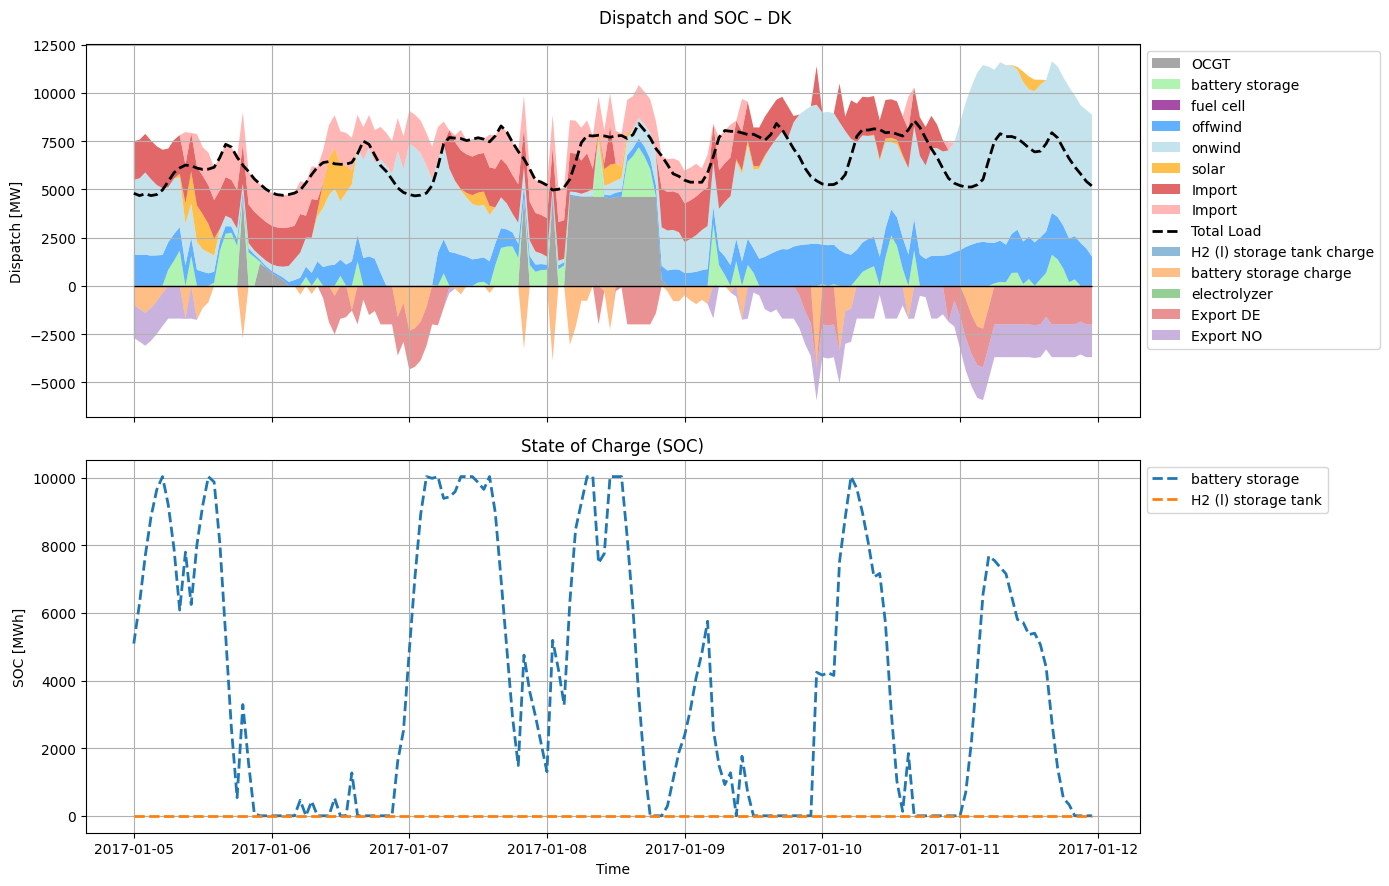

c:\Users\Jeppe Urup Byberg\OneDrive\Dokumenter\GitHub\ieg\Plot_scripts\DispatchSoCInternational.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  fallback_cmap = cm.get_cmap('tab20')  # or any other colormap


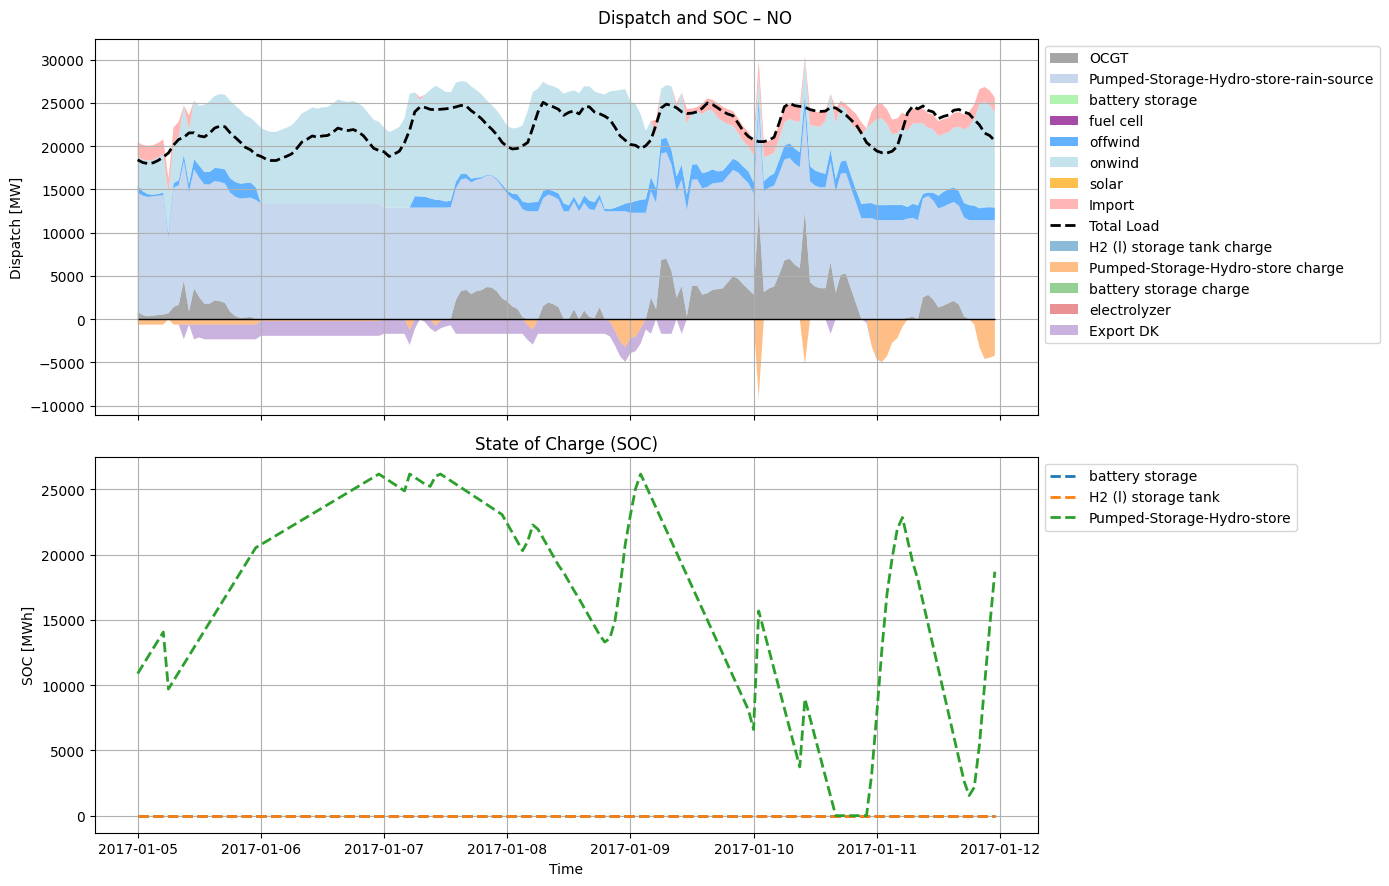

In [64]:
from Plot_scripts.DispatchSoCInternational import PlotInternationalDispatchSoC
from ExpandedNetwork import ExpandedNetwork
from silent_optimize import silent_optimize
from Plot_scripts.AnnualElectricityMix import AnnualElectricityMix


year = 2017
cost_year = 2030
demand_year = 2019,
setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            },
        'DE': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            },
        'NO': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            'Pumped-Storage-Hydro-store': True,
            }
            }

International_Network = ExpandedNetwork(year = 2017, cost_year = 2030, setup = setup, demand_year=2019)
regions = list(International_Network.regions)

#Link between DK and DE
International_Network.network.add("Link",
             f'{regions[0]} - {regions[1]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[1]}",
             p_nom_extendable=True, # capacity is optimised
             p_nom_max = 2000, # max capacity is 1000 MW
             p_min_pu=-1,
             efficiency=0.95,
             capital_cost=International_Network.costs.at['HVAC overhead', "capital_cost"] * 550,
             ) 

#Link between DK and NO
International_Network.network.add("Link",
             f'{regions[0]} - {regions[2]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[2]}",
             p_nom_extendable=True, # capacity is optimised
             p_nom_max = 1700, # max capacity is 1700 MW
             p_min_pu=-1,
             efficiency=0.99,
             capital_cost=International_Network.costs.at['HVDC submarine', "capital_cost"] * 240
             ) 

co2_price = 150  # €/tCO2

# Add CO2 cost directly to OCGT DK generator
gas_generator_name = "OCGT DK"
gas_carrier = "OCGT"
co2_intensity = International_Network.costs.at[gas_carrier, "CO2 intensity"]  # tCO2/MWh_th
co2_cost = co2_price * co2_intensity  # €/MWh_th

if gas_generator_name in International_Network.network.generators.index:
    International_Network.network.generators.at[gas_generator_name, 'marginal_cost'] += co2_cost
    print(f"Updated marginal cost for {gas_generator_name}: {International_Network.network.generators.at[gas_generator_name, 'marginal_cost']} €/MWh")
else:
    print(f"Warning: Generator '{gas_generator_name}' not found in network.")

silent_optimize(International_Network.network)
PlotInternationalDispatchSoC(International_Network, start="2017-01-05 00:00", end="2017-01-11 23:00")

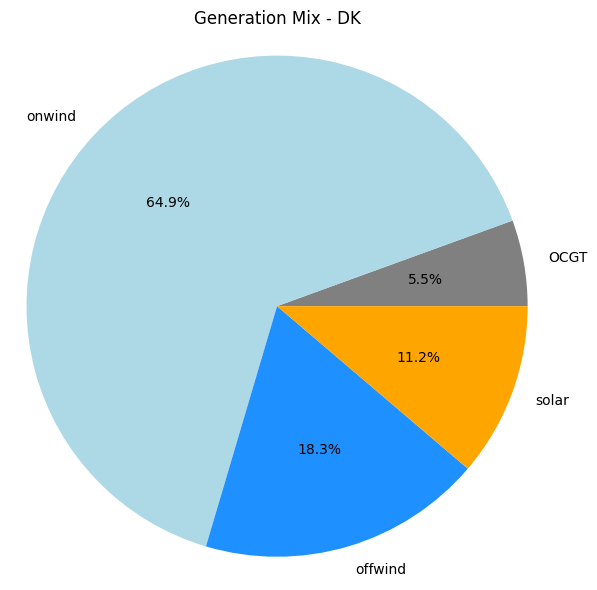

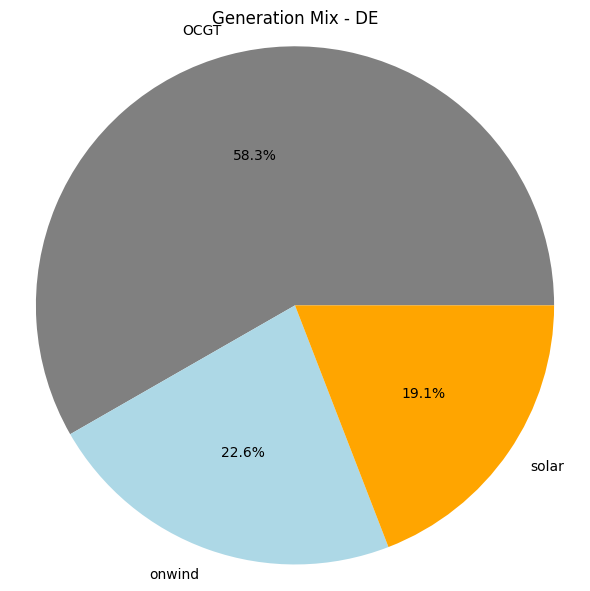

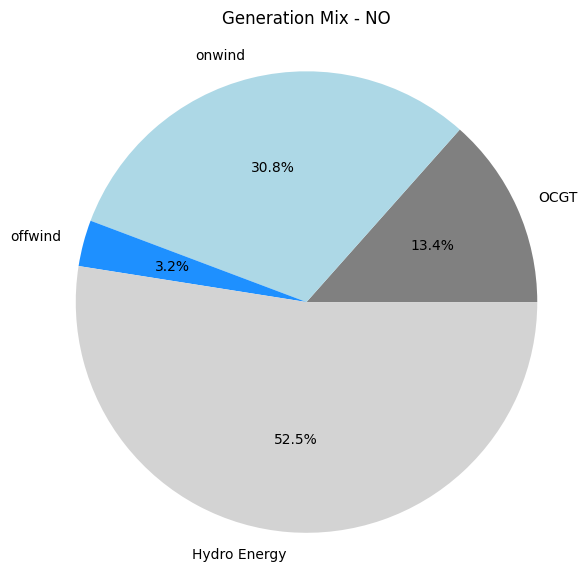

In [67]:
from CostGeneration import CostGeneration 

def plot_generation_mix(network, region):
    """
    Plot a pie chart of energy generation by technology for a given region.
    Adjusts pumped hydro by its efficiency.
    """
    costs = CostGeneration().costs

    # 1. Get total energy produced per generator (sum over time)
    gen_energy = network.network.generators_t.p.sum()

    # 2. Initialize result dictionary
    gen_energy_by_tech = {}

    for col, val in gen_energy.items():
        tech = ' '.join(col.split(' ')[:-1])  # Remove region suffix
        region_col = col.split(' ')[-1]

        if region_col != region:
            continue

        if "Pumped-Storage-Hydro" in tech:
            continue  # We'll add it separately with correction

        if val > 0:
            gen_energy_by_tech[tech] = gen_energy_by_tech.get(tech, 0) + val

    # 3. Add corrected energy input from pumped hydro (optional)
    turbine_link = f'Pumped-Storage-Hydro-store-turbine {region}'
    if turbine_link in network.network.links_t.p1.columns:
        pumped_out = -network.network.links_t.p1[turbine_link].sum()
        gen_energy_by_tech["Hydro Energy"] = pumped_out

    # 4. Prepare labels and sizes
    labels = list(gen_energy_by_tech.keys())
    sizes = list(gen_energy_by_tech.values())

    # 5. Map colors
    colors = [network.colors.get(label, "lightgray") for label in labels]

    # 6. Plot
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
    plt.title(f'Generation Mix - {region}')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

plot_generation_mix(International_Network, 'DK')
plot_generation_mix(International_Network, 'DE')
plot_generation_mix(International_Network, 'NO')

In [ ]:
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
from shapely.errors import ShapelyDeprecationWarning

gen = International_Network.network.generators_t.p.mean().groupby(
    International_Network.network.generators.bus
).sum()

# Safe reindex to include all buses
gen = gen.reindex(International_Network.network.buses.index).fillna(0)

plt.figure(figsize=(12, 8))  # Adjust size here

International_Network.network.plot(
    bus_sizes=gen / 5e4,
    margin=0.5,
    line_widths=1,
    link_widths=1,
    projection=ccrs.EqualEarth(),
    color_geomap=True,
)
plt.show()


# Task G

In [ ]:
from ExpandedHeatNetwork import ExpandedHeatNetwork
from silent_optimize import silent_optimize
from Plot_scripts.DispatchSoCHeatInternational import PlotInternationalDispatchSoCHeat
from Plot_scripts.AnnualElectricityMix import AnnualElectricityMix

setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            'industrial heat pump high temperature': True,
            },
        'DE': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            'industrial heat pump high temperature': True,
            },
        'NO': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            'industrial heat pump high temperature': True,
            'Pumped-Storage-Hydro-store': True,
            }
}

year = 2017
cost_year = 2030
demand_year = 2019,
Expanded_Heat_Network = ExpandedHeatNetwork(year = year, cost_year = cost_year, setup = setup, demand_year=demand_year)

regions = list(Expanded_Heat_Network.regions)

#Link between DK and DE
Expanded_Heat_Network.network.add("Link",
             f'{regions[0]} - {regions[1]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[1]}",
             p_nom_extendable=True, # capacity is optimised
             p_nom_max = 2000, # max capacity is 2000 MW
             p_min_pu=-1,
             efficiency=0.95,
             capital_cost=Expanded_Heat_Network.costs.at['HVAC overhead', "capital_cost"] * 550,
             ) 


#Link between DK and NO
Expanded_Heat_Network.network.add("Link",
             f'{regions[0]} - {regions[2]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[2]}",
             p_nom_extendable=True, # capacity is optimised
             p_nom_max = 1700, # max capacity is 1700 MW
             p_min_pu=-1,
             efficiency=0.99,
             capital_cost=Expanded_Heat_Network.costs.at['HVDC submarine', "capital_cost"] * 240
             ) 

co2_price = 150  # €/tCO2

# Add CO2 cost directly to OCGT DK generator
gas_generator_name = "OCGT DK"
gas_carrier = "OCGT"
co2_intensity = Expanded_Heat_Network.costs.at[gas_carrier, "CO2 intensity"]  # tCO2/MWh_th
co2_cost = co2_price * co2_intensity  # €/MWh_th

if gas_generator_name in Expanded_Heat_Network.network.generators.index:
    Expanded_Heat_Network.network.generators.at[gas_generator_name, 'marginal_cost'] += co2_cost
    print(f"Updated marginal cost for {gas_generator_name}: {Expanded_Heat_Network.network.generators.at[gas_generator_name, 'marginal_cost']} €/MWh")
else:
    print(f"Warning: Generator '{gas_generator_name}' not found in network.")

silent_optimize(Expanded_Heat_Network.network)

PlotInternationalDispatchSoCHeat(Expanded_Heat_Network, start="2017-01-05 00:00", end="2017-01-11 23:00")

# Task H

Updated marginal cost for OCGT DK: 94.3839512195122 €/MWh


Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00,  9.54it/s]


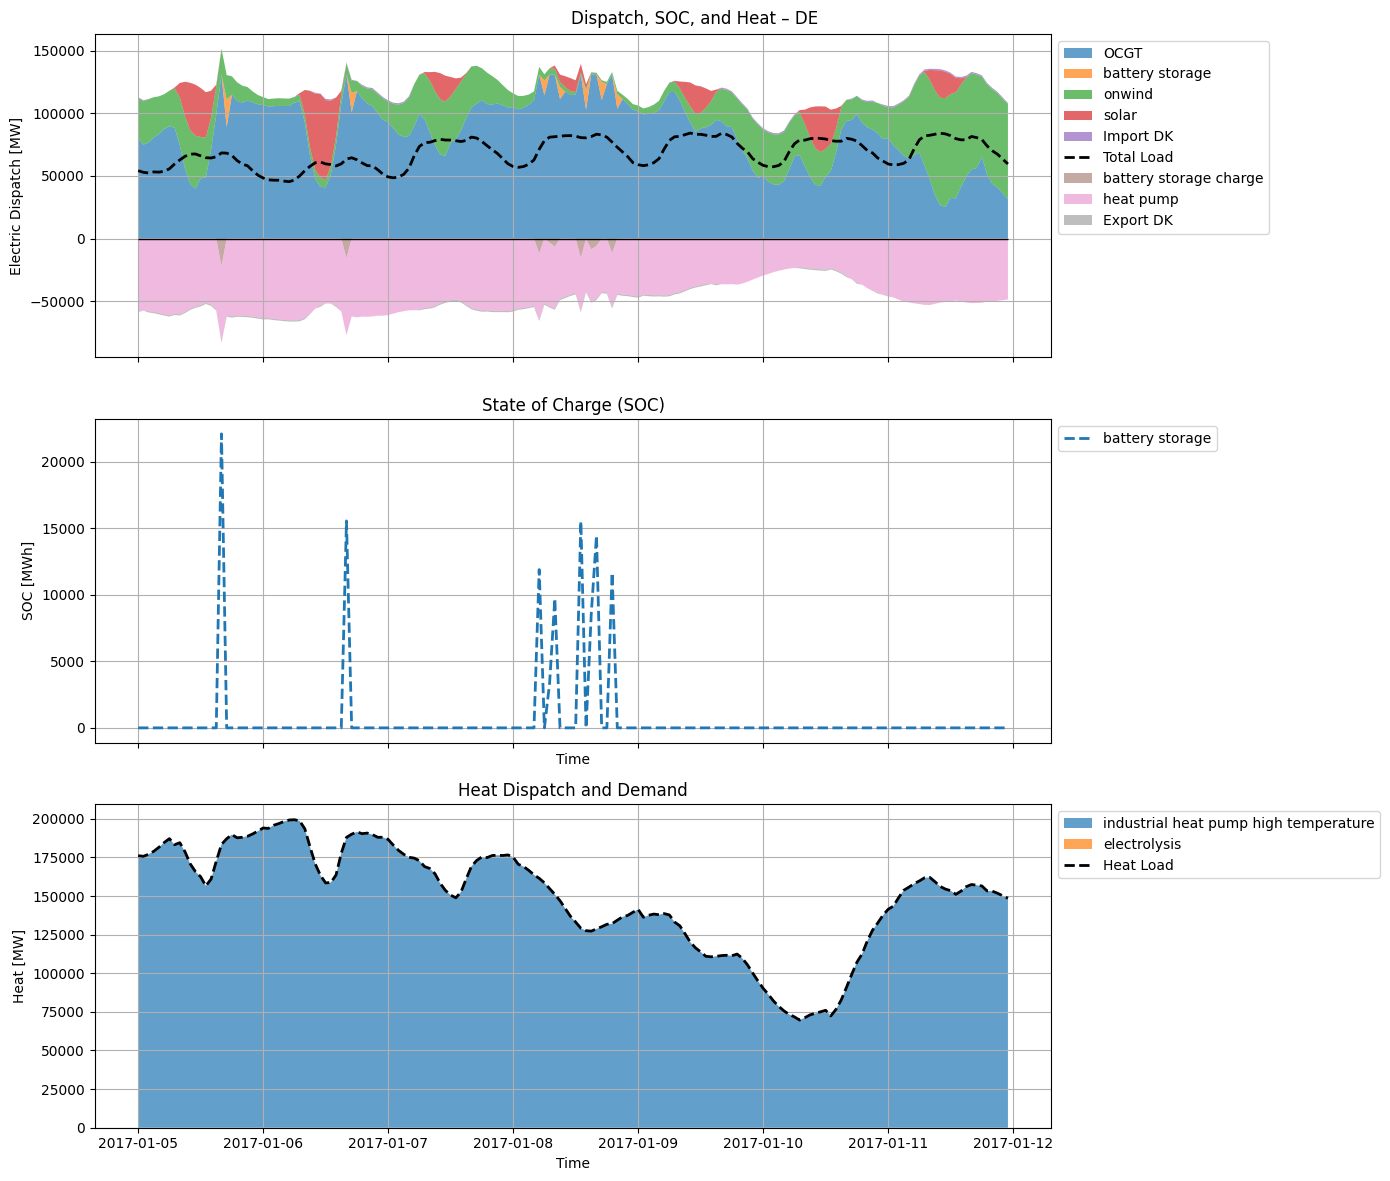

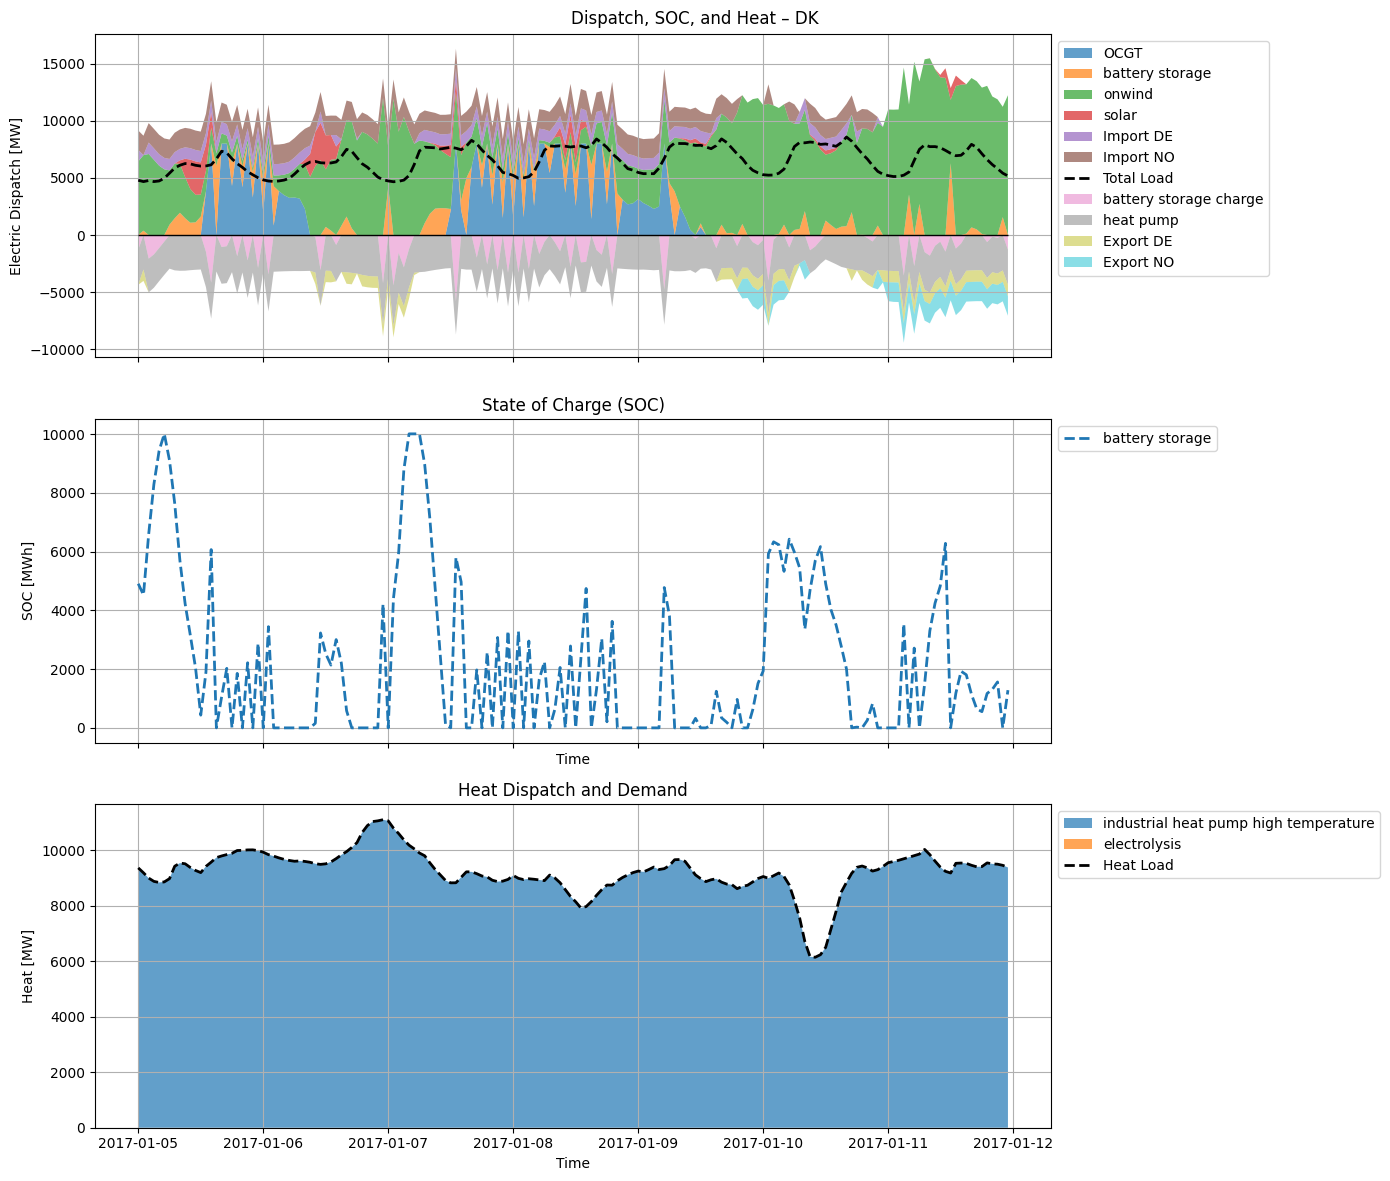

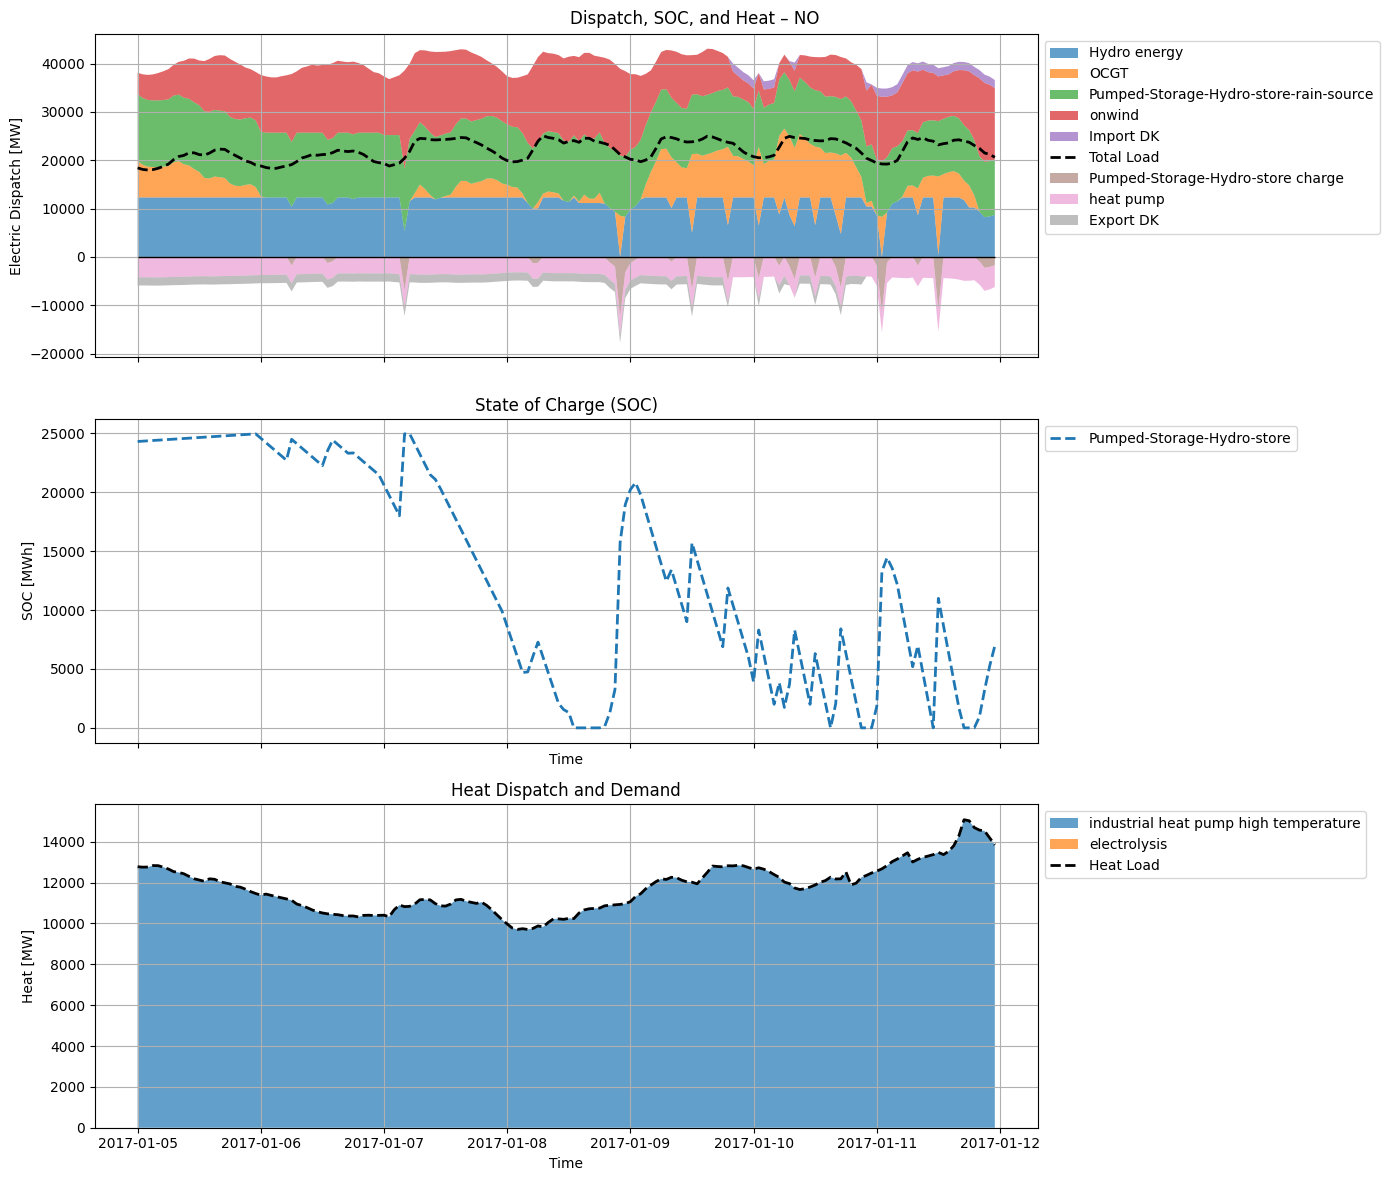

In [68]:
from ExpandedHeatNetwork import ExpandedHeatNetwork
from silent_optimize import silent_optimize
from Plot_scripts.DispatchSoCHeatInternational import PlotInternationalDispatchSoCHeat
from Plot_scripts.AnnualElectricityMix import AnnualElectricityMix

setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            'industrial heat pump high temperature': True,
            },
        'DE': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            'industrial heat pump high temperature': True,
            },
        'NO': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            'industrial heat pump high temperature': True,
            'Pumped-Storage-Hydro-store': True,
            }
}

year = 2017
cost_year = 2030
demand_year = 2019,
Expanded_Heat_Network = ExpandedHeatNetwork(year = year, cost_year = cost_year, setup = setup, demand_year=demand_year)

regions = list(Expanded_Heat_Network.regions)

#Link between DK and DE
Expanded_Heat_Network.network.add("Link",
             f'{regions[0]} - {regions[1]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[1]}",
             p_nom_extendable=True, # capacity is optimised
             p_nom_max = 1000, # max capacity is 1000 MW
             p_min_pu=-1,
             capital_cost=Expanded_Heat_Network.costs.at['HVAC overhead', "capital_cost"] * 550,
             ) 

#Link between DK and NO
Expanded_Heat_Network.network.add("Link",
             f'{regions[0]} - {regions[2]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[2]}",
             p_nom_extendable=True, # capacity is optimised
             p_nom_max = 1700, # max capacity is 1000 MW
             p_min_pu=-1,
             capital_cost=Expanded_Heat_Network.costs.at['HVDC submarine', "capital_cost"] * 240
             ) 

co2_price = 150  # €/tCO2

#Link between DK and DE
Expanded_Heat_Network.network.add("Link",
             f'{regions[0]} - {regions[1]}',
             bus0=f"hydrogen bus {regions[0]}",
             bus1=f"hydrogen bus {regions[1]}",
             p_nom_extendable=False,
             p_nom = 1000, # max capacity is 1000 MW
             p_min_pu=-1,
             capital_cost=Expanded_Heat_Network.costs.at['H2 (g) pipeline', "capital_cost"] * 550,
            # capital_cost=Expanded_Heat_Network.costs.at['H2 (g) pipeline', "capital_cost"] * 0,
             ) 


# Add CO2 cost directly to OCGT DK generator
gas_generator_name = "OCGT DK"
gas_carrier = "OCGT"
co2_intensity = Expanded_Heat_Network.costs.at[gas_carrier, "CO2 intensity"]  # tCO2/MWh_th
co2_cost = co2_price * co2_intensity  # €/MWh_th

if gas_generator_name in Expanded_Heat_Network.network.generators.index:
    Expanded_Heat_Network.network.generators.at[gas_generator_name, 'marginal_cost'] += co2_cost
    print(f"Updated marginal cost for {gas_generator_name}: {Expanded_Heat_Network.network.generators.at[gas_generator_name, 'marginal_cost']} €/MWh")
else:
    print(f"Warning: Generator '{gas_generator_name}' not found in network.")

silent_optimize(Expanded_Heat_Network.network)

PlotInternationalDispatchSoCHeat(Expanded_Heat_Network, start="2017-01-05 00:00", end="2017-01-11 23:00")

In [ ]:
Expanded_Heat_Network = ExpandedHeatNetwork(year = year, cost_year = cost_year, setup = setup, demand_year=demand_year)

regions = list(Expanded_Heat_Network.regions)

#Link between DK and DE
Expanded_Heat_Network.network.add("Link",
             f'{regions[0]} - {regions[1]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[1]}",
             p_nom_extendable=True, # capacity is optimised
             p_nom_max = 1000, # max capacity is 1000 MW
             p_min_pu=-1,
             capital_cost=Expanded_Heat_Network.costs.at['HVAC overhead', "capital_cost"] * 550,
             ) 

#Link between DK and NO
Expanded_Heat_Network.network.add("Link",
             f'{regions[0]} - {regions[2]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[2]}",
             p_nom_extendable=True, # capacity is optimised
            #  p_nom_max = 1700, # max capacity is 1700 MW
             p_min_pu=-1,
             capital_cost=Expanded_Heat_Network.costs.at['HVDC submarine', "capital_cost"] * 240
             ) 

co2_price = 150  # €/tCO2

#Link between DK and DE
Expanded_Heat_Network.network.add("Link",
             f'{regions[0]} - {regions[1]}',
             bus0=f"hydrogen bus {regions[0]}",
             bus1=f"hydrogen bus {regions[1]}",
             p_nom_extendable=False,
             p_nom = 1000, # max capacity is 1000 MW
             p_min_pu=-1,
             capital_cost=Expanded_Heat_Network.costs.at['H2 (g) pipeline', "capital_cost"] * 550,
            # capital_cost=Expanded_Heat_Network.costs.at['H2 (g) pipeline', "capital_cost"] * 0,
             ) 


# Add CO2 cost directly to OCGT DK generator
gas_generator_name = "OCGT DK"
gas_carrier = "OCGT"
co2_intensity = Expanded_Heat_Network.costs.at[gas_carrier, "CO2 intensity"]  # tCO2/MWh_th
co2_cost = co2_price * co2_intensity  # €/MWh_th

if gas_generator_name in Expanded_Heat_Network.network.generators.index:
    Expanded_Heat_Network.network.generators.at[gas_generator_name, 'marginal_cost'] += co2_cost
    print(f"Updated marginal cost for {gas_generator_name}: {Expanded_Heat_Network.network.generators.at[gas_generator_name, 'marginal_cost']} €/MWh")
else:
    print(f"Warning: Generator '{gas_generator_name}' not found in network.")

silent_optimize(Expanded_Heat_Network.network)

PlotInternationalDispatchSoCHeat(Expanded_Heat_Network, start="2017-01-05 00:00", end="2017-01-11 23:00")